This notebook is dedicated to explore potential race-based bias in police killings, based on the Police Violence dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.rcParams['figure.dpi']= 300 #For a higher resolution of the plots

***

# Exploration of potential bias

In [3]:
PV_data = pd.read_csv('./data/police_violence.csv', index_col=0)
PV_data.head()

,victim_age,victim_gender,victim_race,date,City,State,cause_of_death,criminal_charges,victim_armed,alleged_weapon,victim_fleeing
0,66.0,Male,hispanic,2020,Tyler,TX,Gunshot,No known charges,Allegedly Armed,unknown weapon,not fleeing
2,28.0,Male,white,2020,St. Augustine,FL,Gunshot,No known charges,Allegedly Armed,gun,NaN
7,35.0,Male,white,2020,Meredith,NH,Gunshot,No known charges,Unclear,undetermined,NaN
8,38.0,Male,hispanic,2020,Sacramento,CA,Gunshot,No known charges,Allegedly Armed,gun,NaN
10,40.0,Male,white,2020,Cantonment,FL,Gunshot,No known charges,Vehicle,vehicle,car


In [4]:
total = len(PV_data)

In [5]:
races = ["white", "black", "hispanic"]

### Race bias in criminal charges:

In [6]:
uncharged_percts = [] #uncharged percentages

for race in races:
    df = PV_data.query('victim_race == @race')
    total_victims = len(df)
    count_df = df.groupby('criminal_charges').count()
    #count_uncharged is the count of cases where the police didn't get criminal charges for the murder
    count_uncharged = count_df.loc['No known charges':'No known charges', 'State'][0] #we use the column `State` to do the slicing because it has zero NaN values. 
    
    uncharged_percent = np.around(count_uncharged / total_victims * 100)
    uncharged_percts.append(uncharged_percent)
    print("Percentage of police not being charged in case of a %s victim: %4.2f"%(race, uncharged_percent))

Percentage of police not being charged in case of a white victim: 99.00
Percentage of police not being charged in case of a black victim: 97.00
Percentage of police not being charged in case of a hispanic victim: 99.00


### Race bias in killing when the victim is unarmed (or unclear):

In [7]:
unarmed_percts = [] #percentages of being killed while unarmed

for race in races:
    df = PV_data.query('victim_race == @race')
    total_victims = len(df)
    count_df = df.groupby('victim_armed').count()
    count_unarmed = count_df.loc['Unarmed':'Unarmed', 'State'][0] #count_unarmed is the number of unarmed victims
    count_unclear = count_df.loc['Unclear':'Unclear', 'State'][0] #count_unclear is the number of cases where it was unclear if the victim was armed
                                                                  #we use the column `State` to do the slicing because it has zero NaN values. 
    killing_percent = np.around((count_unarmed+count_unclear) / total_victims * 100)
    unarmed_percts.append(killing_percent)
    print("Percentage of being killed while unarmed (or unclear) in case of a %s victim: %4.2f"%(race, killing_percent))

Percentage of being killed while unarmed (or unclear) in case of a white victim: 20.00
Percentage of being killed while unarmed (or unclear) in case of a black victim: 24.00
Percentage of being killed while unarmed (or unclear) in case of a hispanic victim: 25.00


### Race bias in killing based on victim fleeing or not:

In [8]:
not_fleeing_percts = [] #percentages of being killed while not fleeing
for race in races:
    df = PV_data.query('victim_race == @race')
    total_victims = len(df)
    count_df = df.groupby('victim_fleeing').count()
    count_not_fleeing = count_df.loc['not fleeing':'not fleeing', 'State'][0] #count_not_fleeing is the count of victims who were not fleeing the police in the time of the murder
                                                                              #we use the column `State` to do the slicing because it has zero NaN values. 

    killing_percent = np.around(count_not_fleeing / total_victims * 100, decimals=2)
    not_fleeing_percts.append(killing_percent)
    print("Percentage of being killed while not fleeing in case of a %s victim: %4.2f"%(race, killing_percent))

Percentage of being killed while not fleeing in case of a white victim: 48.42
Percentage of being killed while not fleeing in case of a black victim: 40.13
Percentage of being killed while not fleeing in case of a hispanic victim: 43.18


### Distribution of races among victims armed with at least a gun:

In [9]:
df_guns = PV_data.query('alleged_weapon == "gun"')
total = len(df_guns)

In [10]:
count_guns_by_race = df_guns.groupby('victim_race').count()

for race in races:
    c = count_guns_by_race.loc[race:race, 'State'][0]
    prct = c/total * 100
    print("%4.2f percent of victims carrying a gun are %s."%(prct, race))

53.27 percent of victims carrying a gun are white.
29.66 percent of victims carrying a gun are black.
17.07 percent of victims carrying a gun are hispanic.


# Plots

### Police charged, victim unarmed (or unclear), victim not fleeing

In [11]:
white_info = [uncharged_percts[0], unarmed_percts[0], not_fleeing_percts[0]]
black_info = [uncharged_percts[1], unarmed_percts[1], not_fleeing_percts[1]]
hisp_info = [uncharged_percts[2], unarmed_percts[2], not_fleeing_percts[2]]

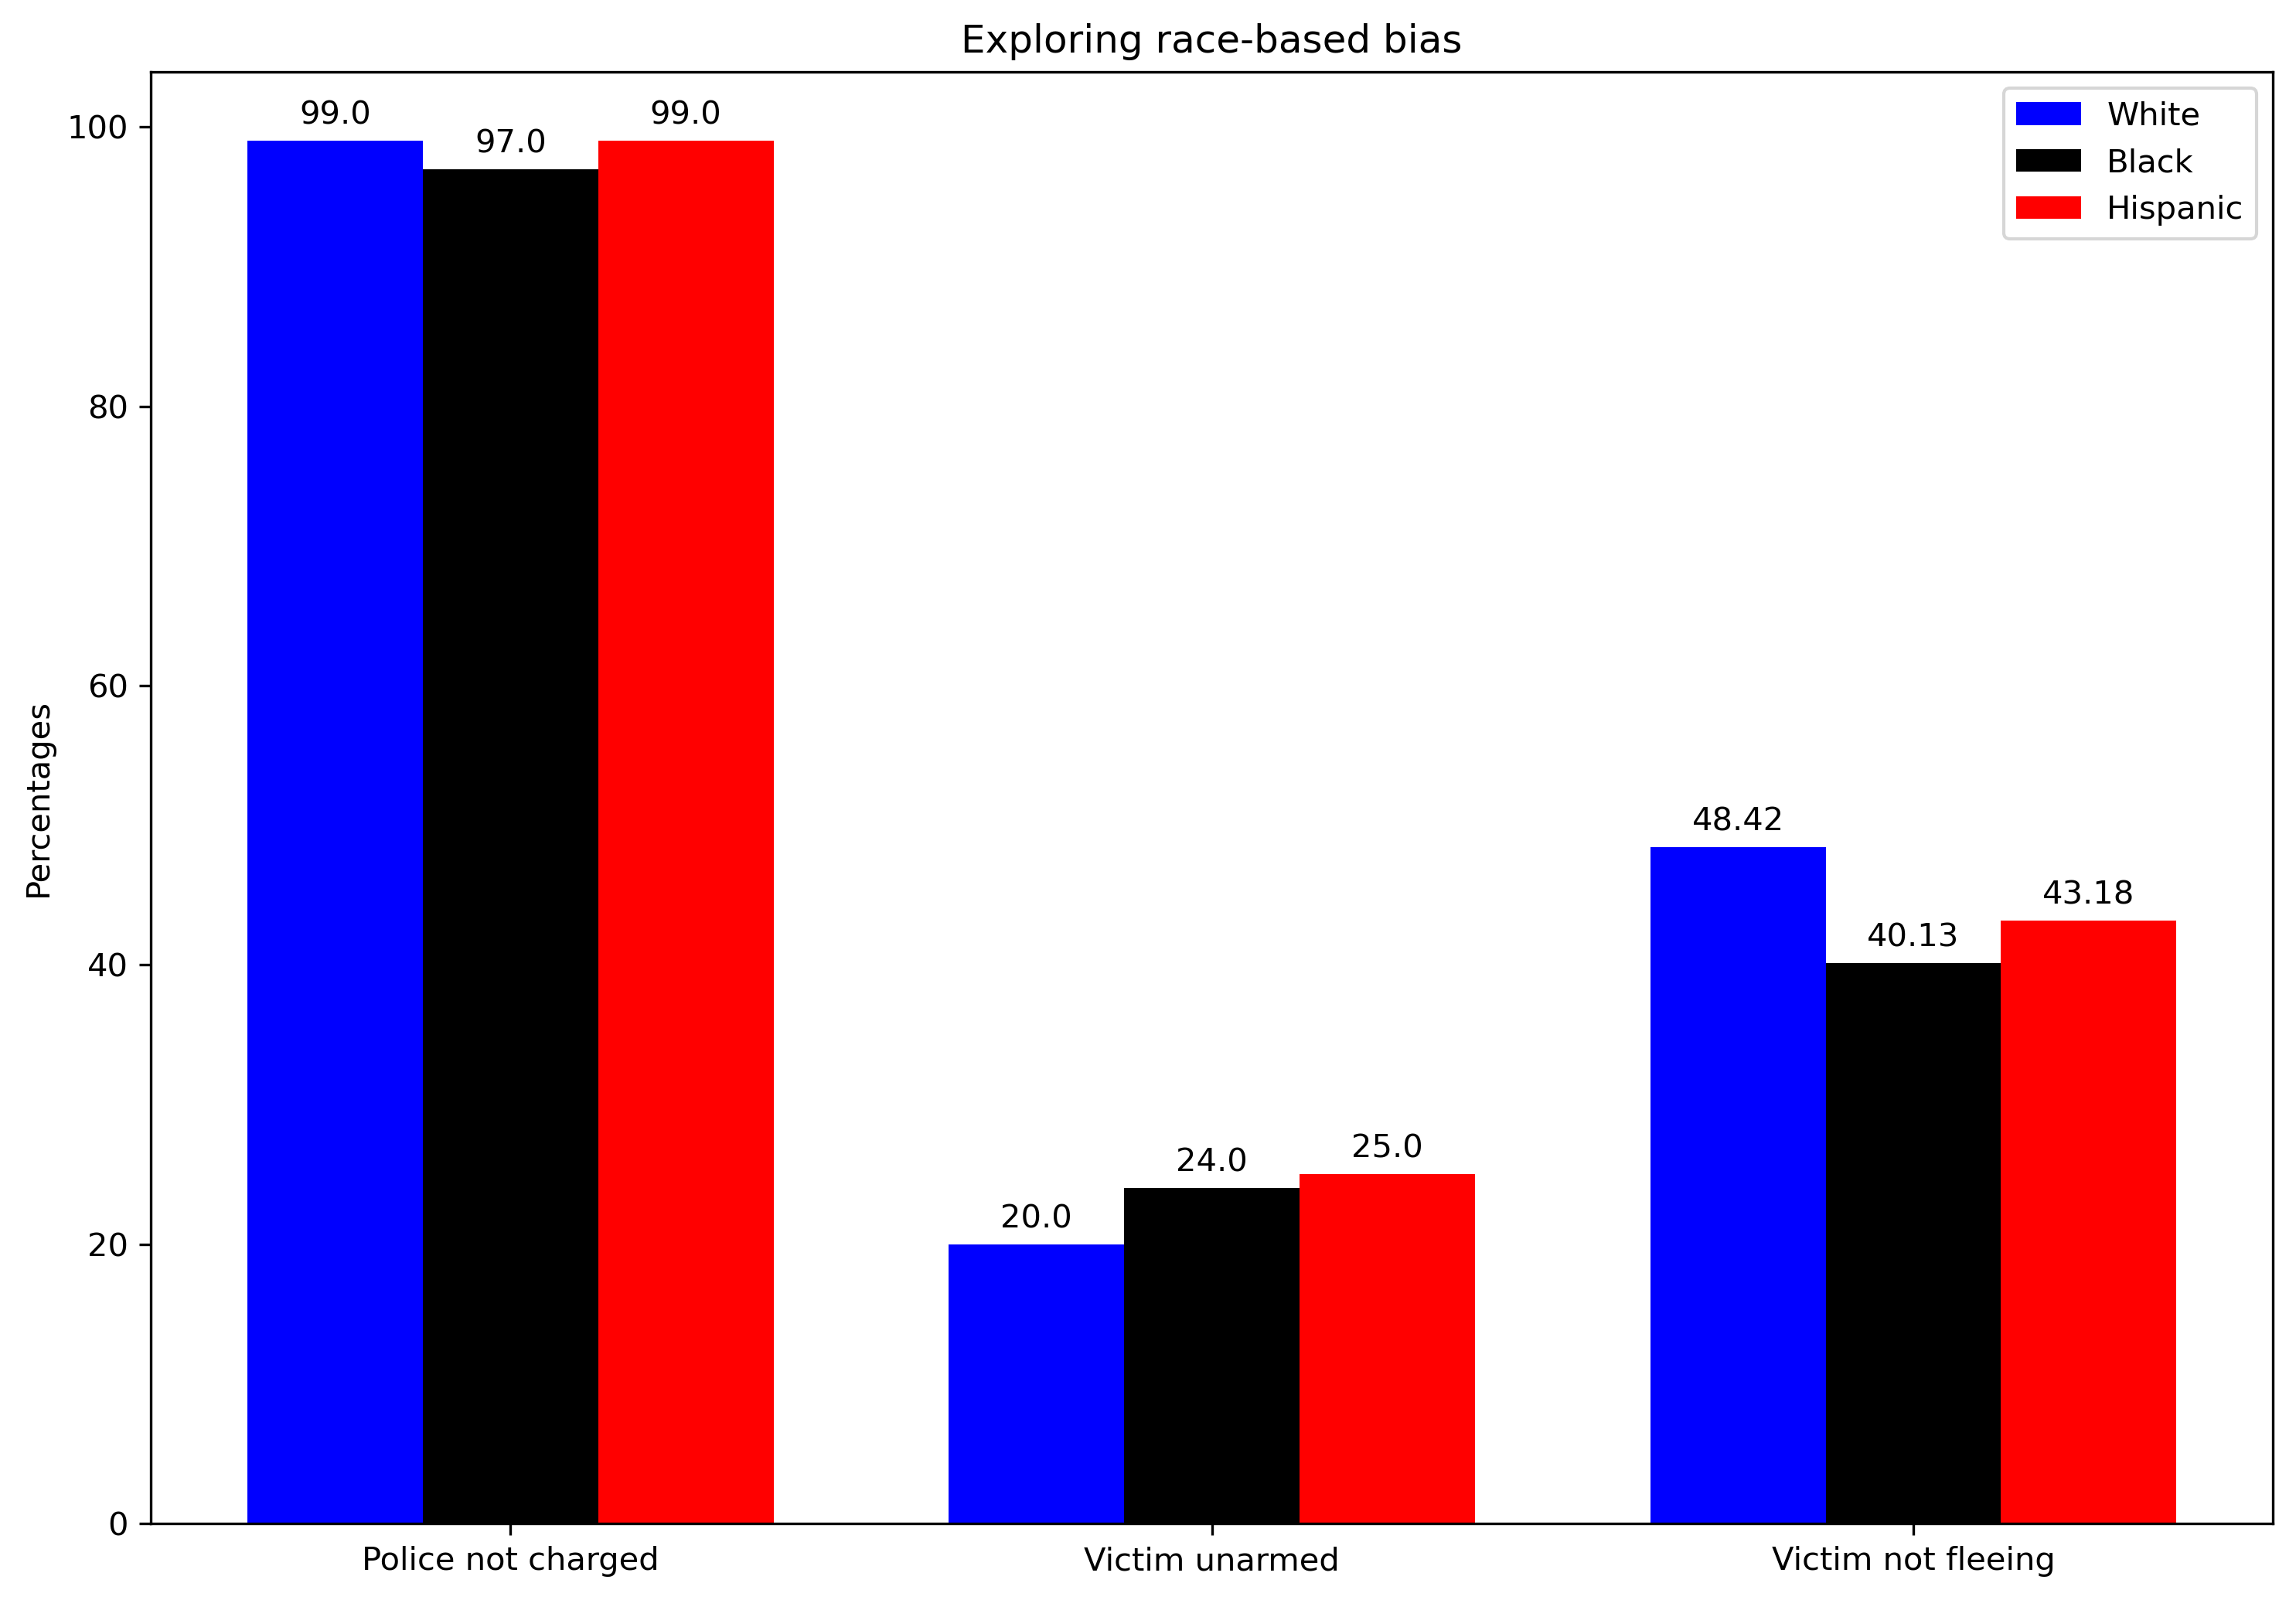

<Figure size 1800x1200 with 0 Axes>

In [12]:
labels = ['Police not charged', 'Victim unarmed', 'Victim not fleeing']

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
fig.set_size_inches(10, 7)

cat1 = ax.bar(x - width, white_info, width, label='White', color="blue")
cat2 = ax.bar(x, black_info, width, label='Black', color="black")
cat3 = ax.bar(x + width, hisp_info, width, label='Hispanic', color="red")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentages')
ax.set_title('Exploring race-based bias')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(cat1)
autolabel(cat2)
autolabel(cat3)

fig.tight_layout()

plt.show()
plt.savefig('./plots/barplot.png')

***

## Change of behavior over time

In [13]:
#keep only "white", "black" and "hispanic"
df_races = PV_data.query('victim_race in @races')

In [14]:
#group by race and year => count the total number of victims by race each year
total_df = df_races.groupby(['victim_race', 'date'], as_index=False).count()
total_df['total_count'] = total_df.State
total_df = total_df[['victim_race', 'date', 'total_count']]
total_df.head()

,victim_race,date,total_count
0,black,2013,287
1,black,2014,277
2,black,2015,305
3,black,2016,279
4,black,2017,276


**Comparison between races in the number of victims carrying a gun, between 2013 and 2020**

In [15]:
PV_data.head()

,victim_age,victim_gender,victim_race,date,City,State,cause_of_death,criminal_charges,victim_armed,alleged_weapon,victim_fleeing
0,66.0,Male,hispanic,2020,Tyler,TX,Gunshot,No known charges,Allegedly Armed,unknown weapon,not fleeing
2,28.0,Male,white,2020,St. Augustine,FL,Gunshot,No known charges,Allegedly Armed,gun,NaN
7,35.0,Male,white,2020,Meredith,NH,Gunshot,No known charges,Unclear,undetermined,NaN
8,38.0,Male,hispanic,2020,Sacramento,CA,Gunshot,No known charges,Allegedly Armed,gun,NaN
10,40.0,Male,white,2020,Cantonment,FL,Gunshot,No known charges,Vehicle,vehicle,car


In [16]:
#group by race, year and weapon => get the number of victims carrying a gun, each year, in every race
guns_df = df_races.groupby(['victim_race', 'date', 'alleged_weapon'], as_index=False).count()
guns_df['gun_count'] = guns_df.State
guns_df = guns_df.query('alleged_weapon == "gun"')
guns_df.head()

,victim_race,date,alleged_weapon,victim_age,victim_gender,City,State,cause_of_death,criminal_charges,victim_armed,victim_fleeing,gun_count
1,black,2013,gun,144,145,145,145,145,145,145,2,145
26,black,2014,gun,121,124,124,124,124,124,124,0,124
47,black,2015,gun,148,149,149,149,149,149,149,140,149
63,black,2016,gun,157,158,158,158,158,158,158,156,158
79,black,2017,gun,155,156,156,156,156,156,156,156,156


In [17]:
final_df = pd.merge(total_df, guns_df, on=['victim_race', 'date'])
final_df['%_carrying_gun'] = np.around(final_df.gun_count / final_df.total_count * 100, decimals=2)
final_df = final_df[['victim_race', 'date', '%_carrying_gun']]
final_df

,victim_race,date,%_carrying_gun
0,black,2013,50.52
1,black,2014,44.77
2,black,2015,48.85
3,black,2016,56.63
4,black,2017,56.52
5,black,2018,54.44
6,black,2019,63.90
7,black,2020,57.58
8,hispanic,2013,46.99
9,hispanic,2014,36.26


Text(0, 0.5, '% of victims carrying a gun')

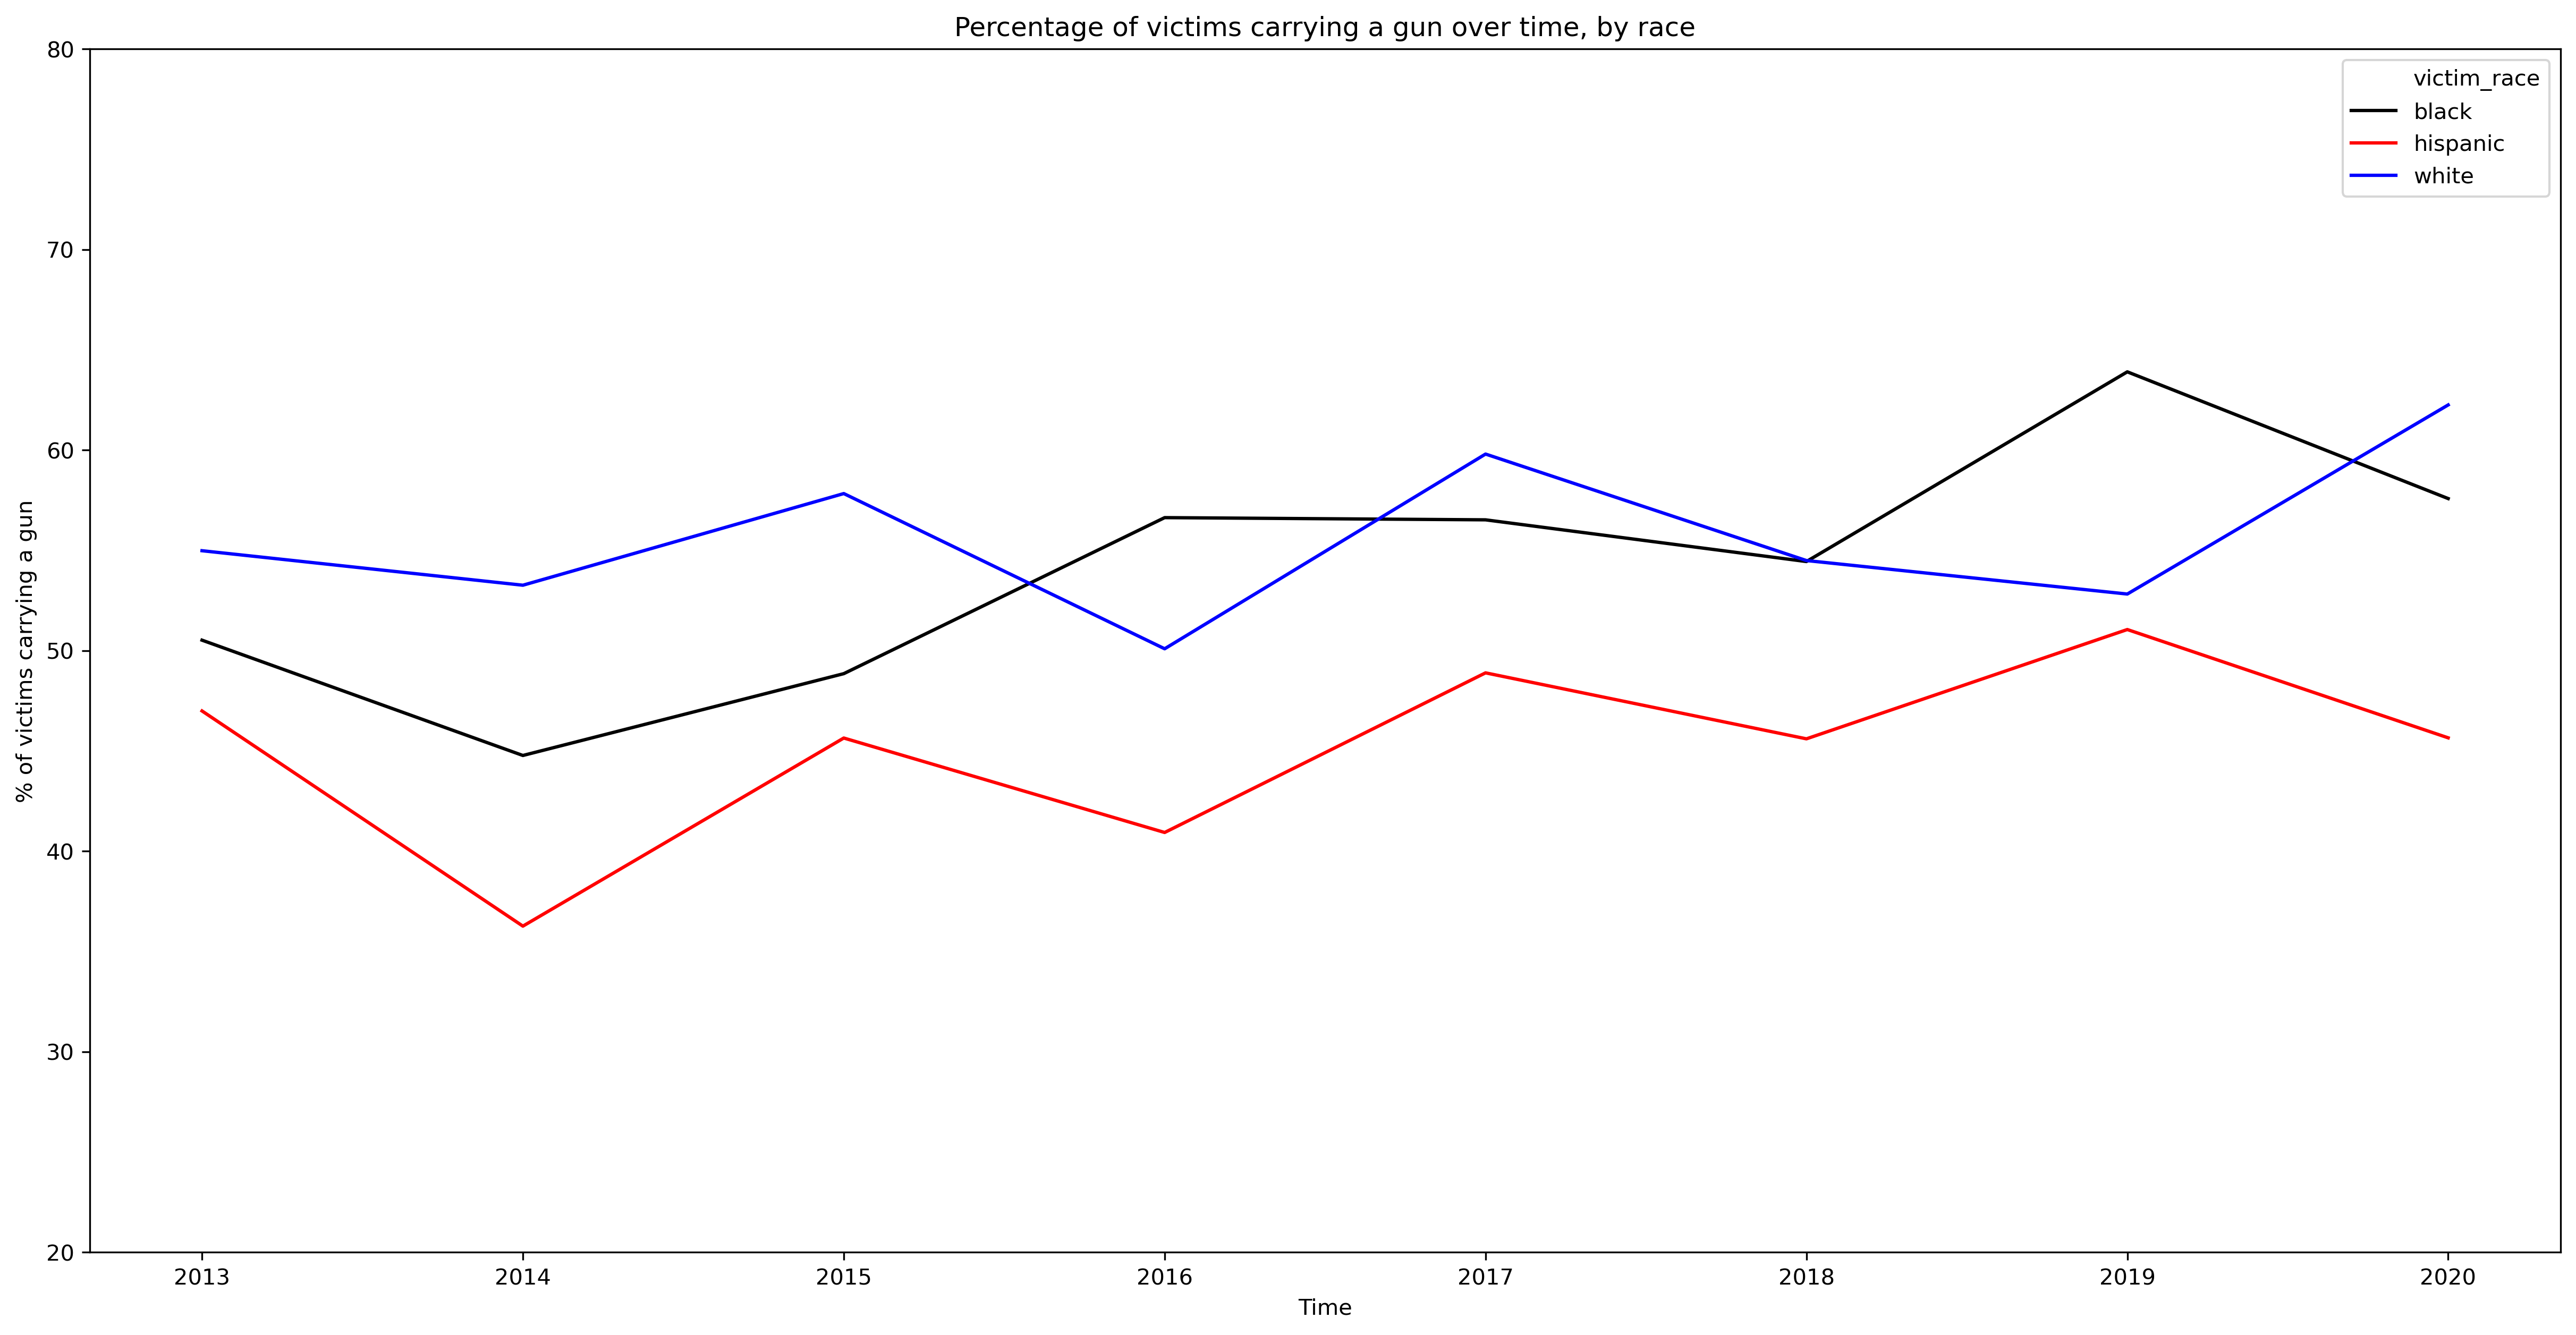

In [18]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)

sns.lineplot(data=final_df, x="date", y="%_carrying_gun", hue="victim_race", palette=["black", "red", "blue"])

ax.set_ylim(20,80)

ax.set_title("Percentage of victims carrying a gun over time, by race")
ax.set_xlabel("Time")
ax.set_ylabel("% of victims carrying a gun")

**Comparison between races in the number of victims not fleeing the police when killed, between 2013 and 2020**

In [19]:
PV_data.head()

,victim_age,victim_gender,victim_race,date,City,State,cause_of_death,criminal_charges,victim_armed,alleged_weapon,victim_fleeing
0,66.0,Male,hispanic,2020,Tyler,TX,Gunshot,No known charges,Allegedly Armed,unknown weapon,not fleeing
2,28.0,Male,white,2020,St. Augustine,FL,Gunshot,No known charges,Allegedly Armed,gun,NaN
7,35.0,Male,white,2020,Meredith,NH,Gunshot,No known charges,Unclear,undetermined,NaN
8,38.0,Male,hispanic,2020,Sacramento,CA,Gunshot,No known charges,Allegedly Armed,gun,NaN
10,40.0,Male,white,2020,Cantonment,FL,Gunshot,No known charges,Vehicle,vehicle,car


In [20]:
total_df.head()

,victim_race,date,total_count
0,black,2013,287
1,black,2014,277
2,black,2015,305
3,black,2016,279
4,black,2017,276


In [21]:
#group by race, year and victim_fleeing => get the number of victims not_fleeing, each year, in every race
flee_df = PV_data.groupby(['victim_race', 'date', 'victim_fleeing'], as_index=False).count()
flee_df = flee_df.query('victim_fleeing == "not fleeing"')
flee_df['not_fleeing_count'] = flee_df.State
flee_df.head()

,victim_race,date,victim_fleeing,victim_age,victim_gender,City,State,cause_of_death,criminal_charges,victim_armed,alleged_weapon,not_fleeing_count
1,black,2013,not fleeing,1,1,1,1,1,1,1,1,1
2,black,2014,not fleeing,1,1,1,1,1,1,1,1,1
5,black,2015,not fleeing,175,175,175,175,175,175,175,175,175
9,black,2016,not fleeing,171,172,172,172,172,172,172,172,172
13,black,2017,not fleeing,170,173,173,173,173,173,173,173,173


In [22]:
final_df = pd.merge(total_df, flee_df, on=['victim_race', 'date'])
final_df['%_not_fleeing'] = np.around(final_df.not_fleeing_count / final_df.total_count * 100, decimals=2)
final_df = final_df[['victim_race', 'date', '%_not_fleeing']]
final_df

,victim_race,date,%_not_fleeing
0,black,2013,0.35
1,black,2014,0.36
2,black,2015,57.38
3,black,2016,61.65
4,black,2017,62.68
5,black,2018,52.12
6,black,2019,42.24
7,black,2020,46.46
8,hispanic,2013,0.60
9,hispanic,2015,64.10


Text(0, 0.5, '% of victims not fleeing')

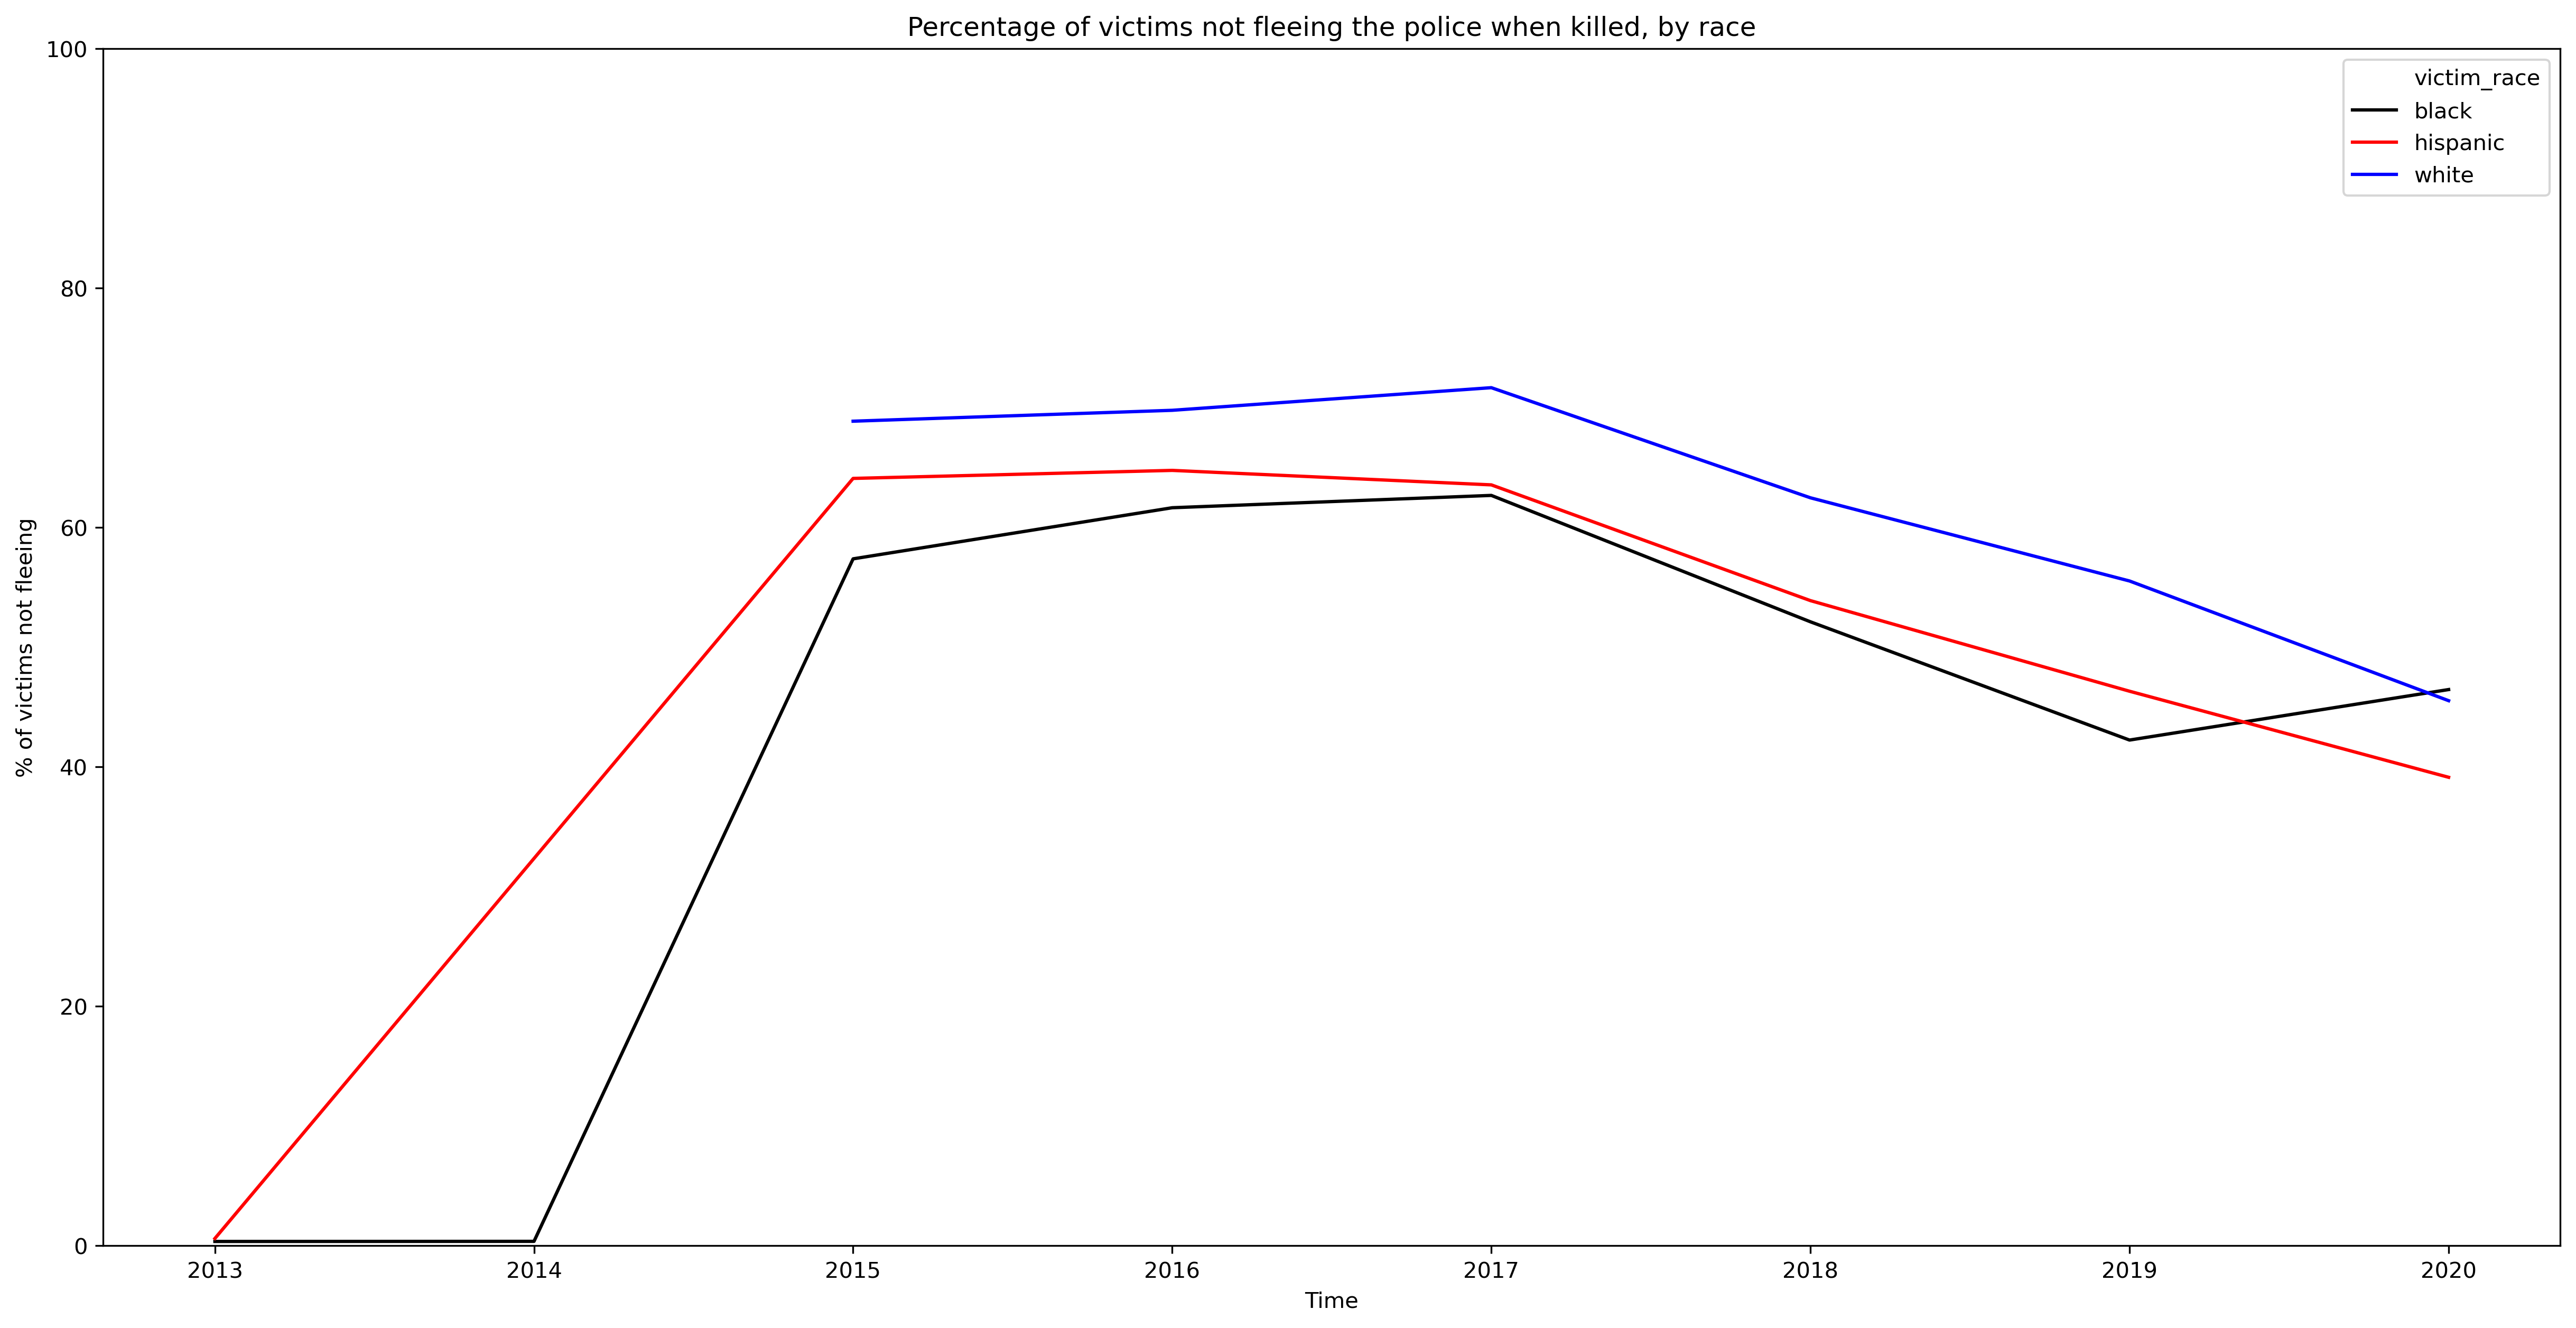

In [23]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)

sns.lineplot(data=final_df, x="date", y="%_not_fleeing", hue="victim_race", palette=["black", "red", "blue"])

ax.set_ylim(0, 100)

ax.set_title("Percentage of victims not fleeing the police when killed, by race")
ax.set_xlabel("Time")
ax.set_ylabel("% of victims not fleeing")

**Comparison between races in the number of victims fleeing the police when killed, between 2013 and 2020**

In [24]:
PV_data.head()

,victim_age,victim_gender,victim_race,date,City,State,cause_of_death,criminal_charges,victim_armed,alleged_weapon,victim_fleeing
0,66.0,Male,hispanic,2020,Tyler,TX,Gunshot,No known charges,Allegedly Armed,unknown weapon,not fleeing
2,28.0,Male,white,2020,St. Augustine,FL,Gunshot,No known charges,Allegedly Armed,gun,NaN
7,35.0,Male,white,2020,Meredith,NH,Gunshot,No known charges,Unclear,undetermined,NaN
8,38.0,Male,hispanic,2020,Sacramento,CA,Gunshot,No known charges,Allegedly Armed,gun,NaN
10,40.0,Male,white,2020,Cantonment,FL,Gunshot,No known charges,Vehicle,vehicle,car


In [25]:
total_df.head()

,victim_race,date,total_count
0,black,2013,287
1,black,2014,277
2,black,2015,305
3,black,2016,279
4,black,2017,276


In [26]:
#group by race, year and victim_fleeing => get the number of victims not_fleeing, each year, in every race
flee_df = PV_data.groupby(['victim_race', 'date', 'victim_fleeing'], as_index=False).count()
flee_df = flee_df.query('victim_fleeing != "not fleeing"')
flee_df = df_races.groupby(['victim_race', 'date', 'victim_fleeing'], as_index=False).count()
flee_df = flee_df.groupby(['victim_race', 'date'], as_index=False).sum()
flee_df['fleeing_count'] = flee_df.State
flee_df.head()

,victim_race,date,victim_age,victim_gender,City,State,cause_of_death,criminal_charges,victim_armed,alleged_weapon,fleeing_count
0,black,2013,3,3,3,3,3,3,3,3,3
1,black,2014,1,1,1,1,1,1,1,1,1
2,black,2015,257,257,257,257,257,257,257,257,257
3,black,2016,275,277,277,277,277,277,277,277,277
4,black,2017,272,276,276,276,276,276,276,276,276


In [27]:
final_df = pd.merge(total_df, flee_df, on=['victim_race', 'date'])
final_df['%_fleeing'] = np.around(final_df.fleeing_count / final_df.total_count * 100, decimals=2)
final_df = final_df[['victim_race', 'date', '%_fleeing']]
final_df

,victim_race,date,%_fleeing
0,black,2013,1.05
1,black,2014,0.36
2,black,2015,84.26
3,black,2016,99.28
4,black,2017,100.00
5,black,2018,86.49
6,black,2019,79.78
7,black,2020,82.32
8,hispanic,2013,0.60
9,hispanic,2015,90.77


Text(0, 0.5, '% of victims fleeing')

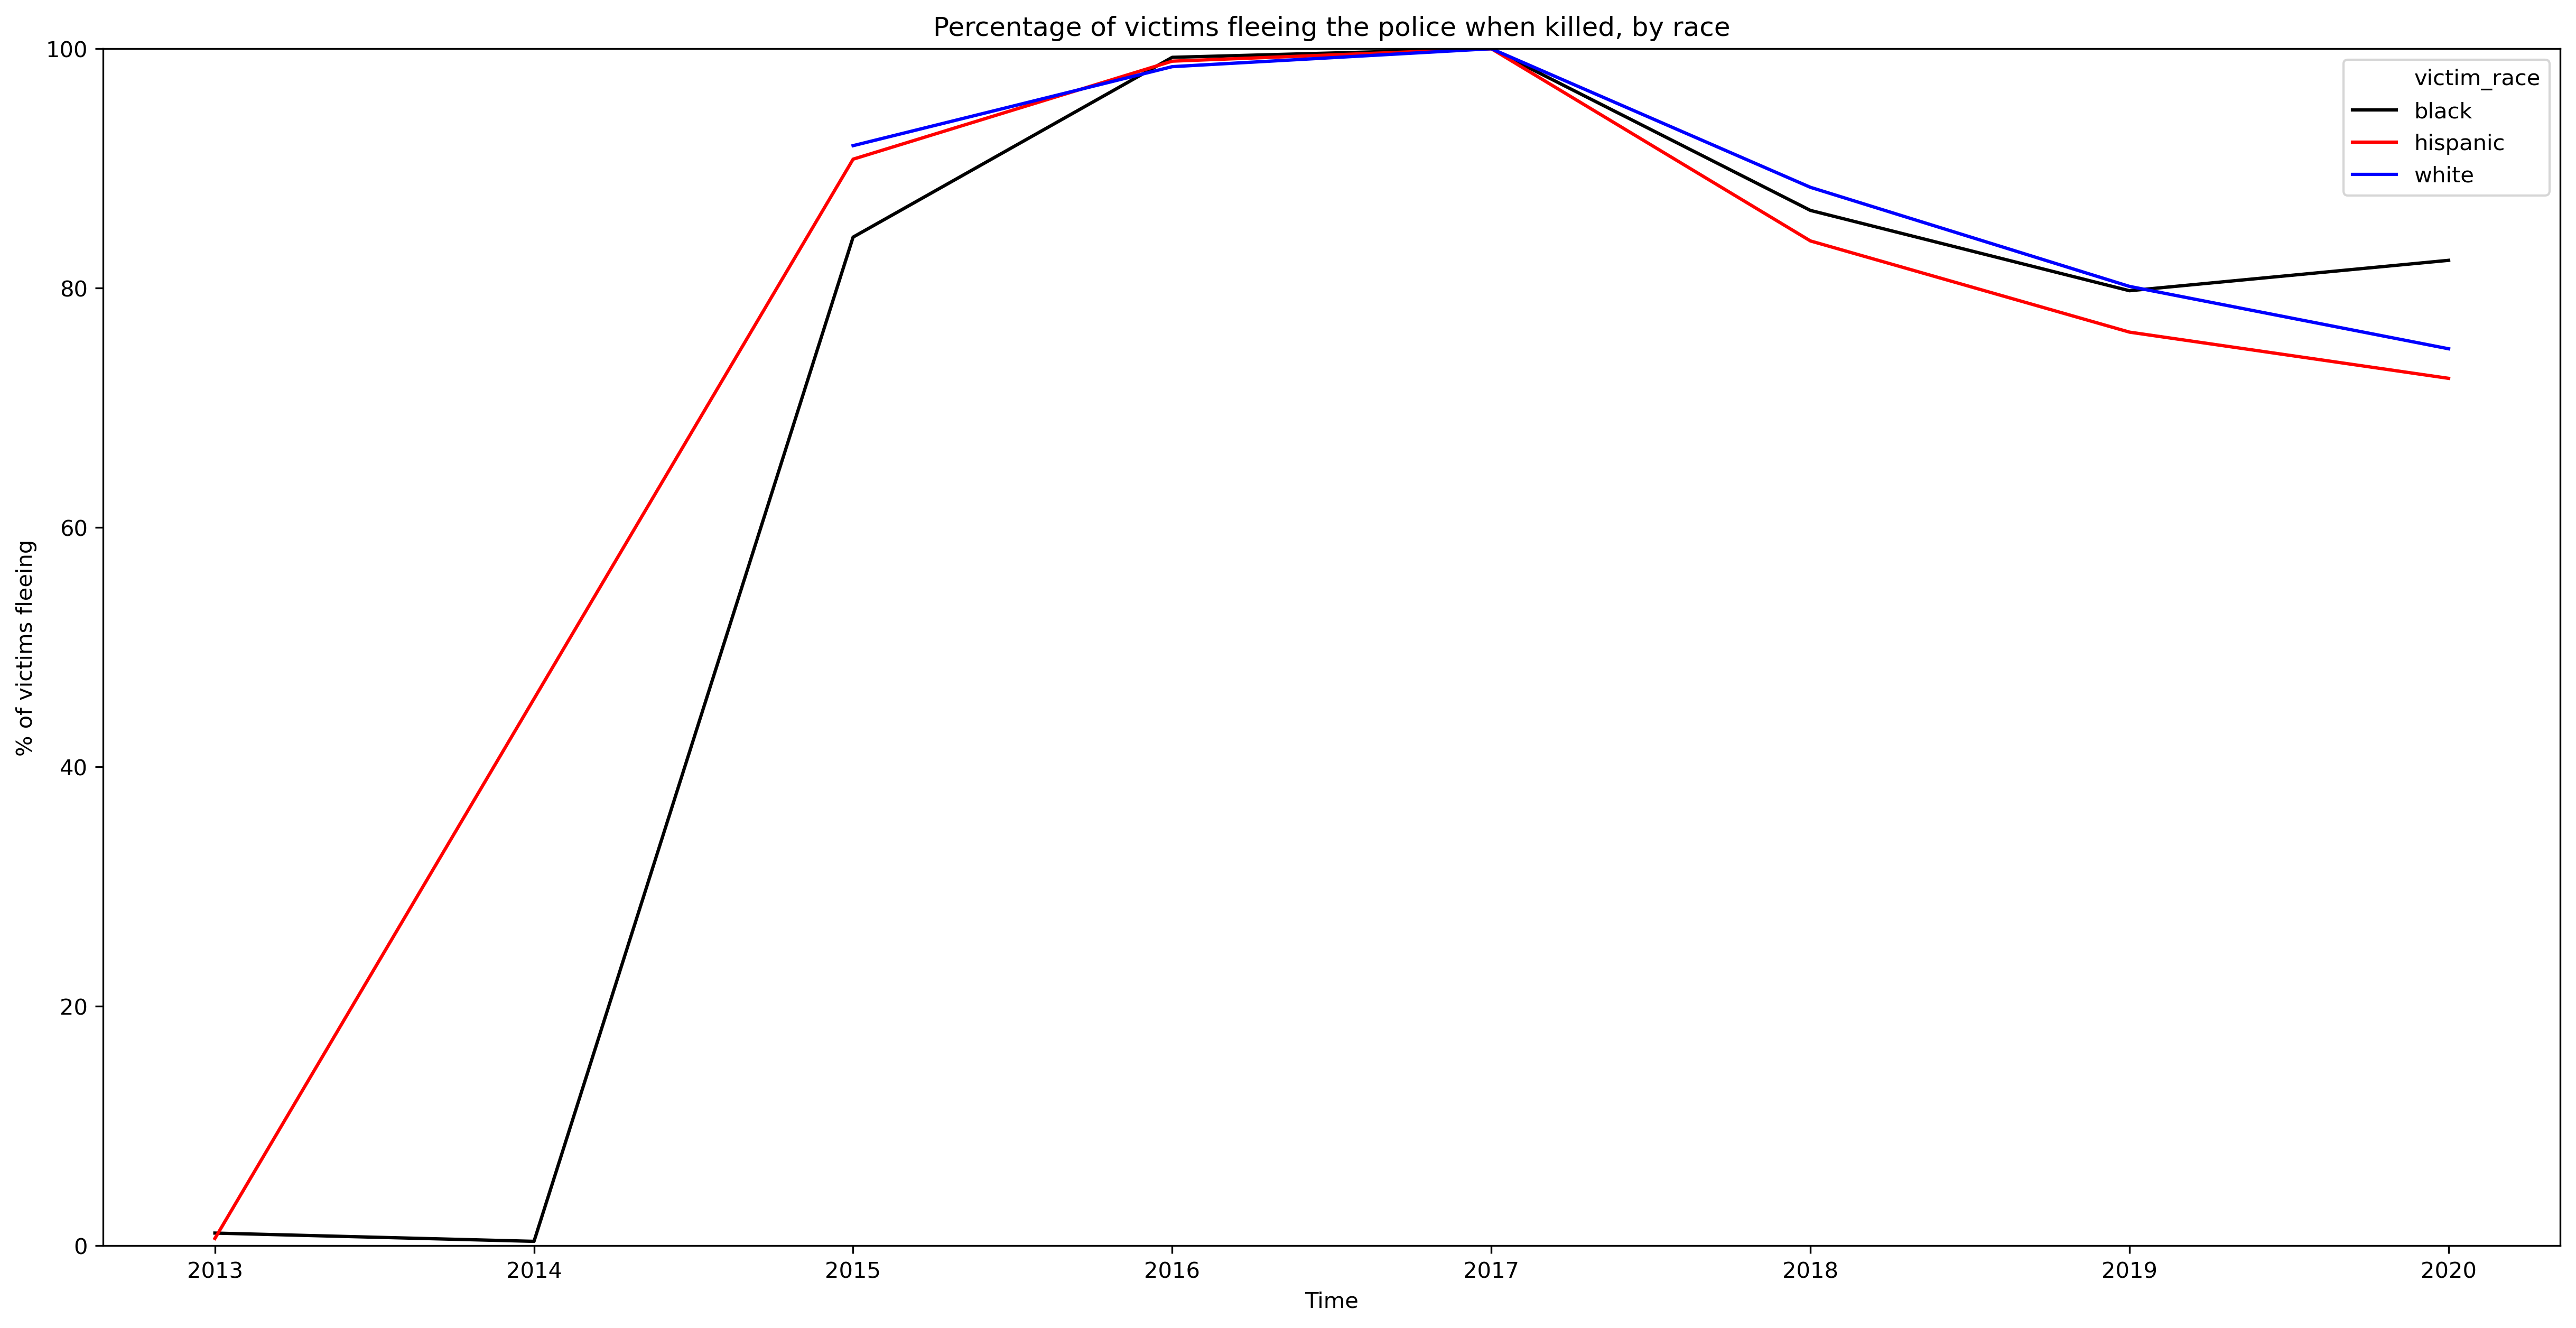

In [28]:
import seaborn as sns

fig, ax = plt.subplots()
fig.set_size_inches(20, 10)

sns.lineplot(data=final_df, x="date", y="%_fleeing", hue="victim_race", palette=["black", "red", "blue"])

ax.set_ylim(0, 100)

ax.set_title("Percentage of victims fleeing the police when killed, by race")
ax.set_xlabel("Time")
ax.set_ylabel("% of victims fleeing")

***

**Comparison between races in the number of unarmed victims, between 2013 and 2020**

In [29]:
PV_data.head()

,victim_age,victim_gender,victim_race,date,City,State,cause_of_death,criminal_charges,victim_armed,alleged_weapon,victim_fleeing
0,66.0,Male,hispanic,2020,Tyler,TX,Gunshot,No known charges,Allegedly Armed,unknown weapon,not fleeing
2,28.0,Male,white,2020,St. Augustine,FL,Gunshot,No known charges,Allegedly Armed,gun,NaN
7,35.0,Male,white,2020,Meredith,NH,Gunshot,No known charges,Unclear,undetermined,NaN
8,38.0,Male,hispanic,2020,Sacramento,CA,Gunshot,No known charges,Allegedly Armed,gun,NaN
10,40.0,Male,white,2020,Cantonment,FL,Gunshot,No known charges,Vehicle,vehicle,car


In [30]:
total_df.head()

,victim_race,date,total_count
0,black,2013,287
1,black,2014,277
2,black,2015,305
3,black,2016,279
4,black,2017,276


In [31]:
PV_data.victim_armed.unique()

array(['Allegedly Armed', 'Unclear', 'Vehicle', 'Unarmed'], dtype=object)

In [32]:
#group by race, year and victim_armed => get the number of victims unarmed, each year, in every race
unarmed_df = PV_data.query('victim_armed in ["Unarmed", "Unclear"]')
unarmed_df = unarmed_df.groupby(['victim_race', 'date', 'victim_armed'], as_index=False).count()
unarmed_df = unarmed_df.groupby(['victim_race', 'date'], as_index=False).sum()
unarmed_df['unarmed_count'] = unarmed_df.State
unarmed_df.head()

,victim_race,date,victim_age,victim_gender,City,State,cause_of_death,criminal_charges,alleged_weapon,victim_fleeing,unarmed_count
0,black,2013,82,82,82,82,82,82,82,1,82
1,black,2014,95,95,95,95,95,95,95,0,95
2,black,2015,87,87,87,87,87,87,87,56,87
3,black,2016,71,72,72,72,72,72,72,72,72
4,black,2017,60,60,60,60,60,60,60,60,60


In [33]:
final_df = pd.merge(total_df, unarmed_df, on=['victim_race', 'date'])
final_df['%_unarmed'] = np.around(final_df.unarmed_count / final_df.total_count * 100, decimals=2)
final_df = final_df[['victim_race', 'date', '%_unarmed']]
final_df

,victim_race,date,%_unarmed
0,black,2013,28.57
1,black,2014,34.30
2,black,2015,28.52
3,black,2016,25.81
4,black,2017,21.74
5,black,2018,20.46
6,black,2019,14.44
7,black,2020,19.70
8,hispanic,2013,24.10
9,hispanic,2014,31.32


Text(0, 0.5, '% of unarmed victims')

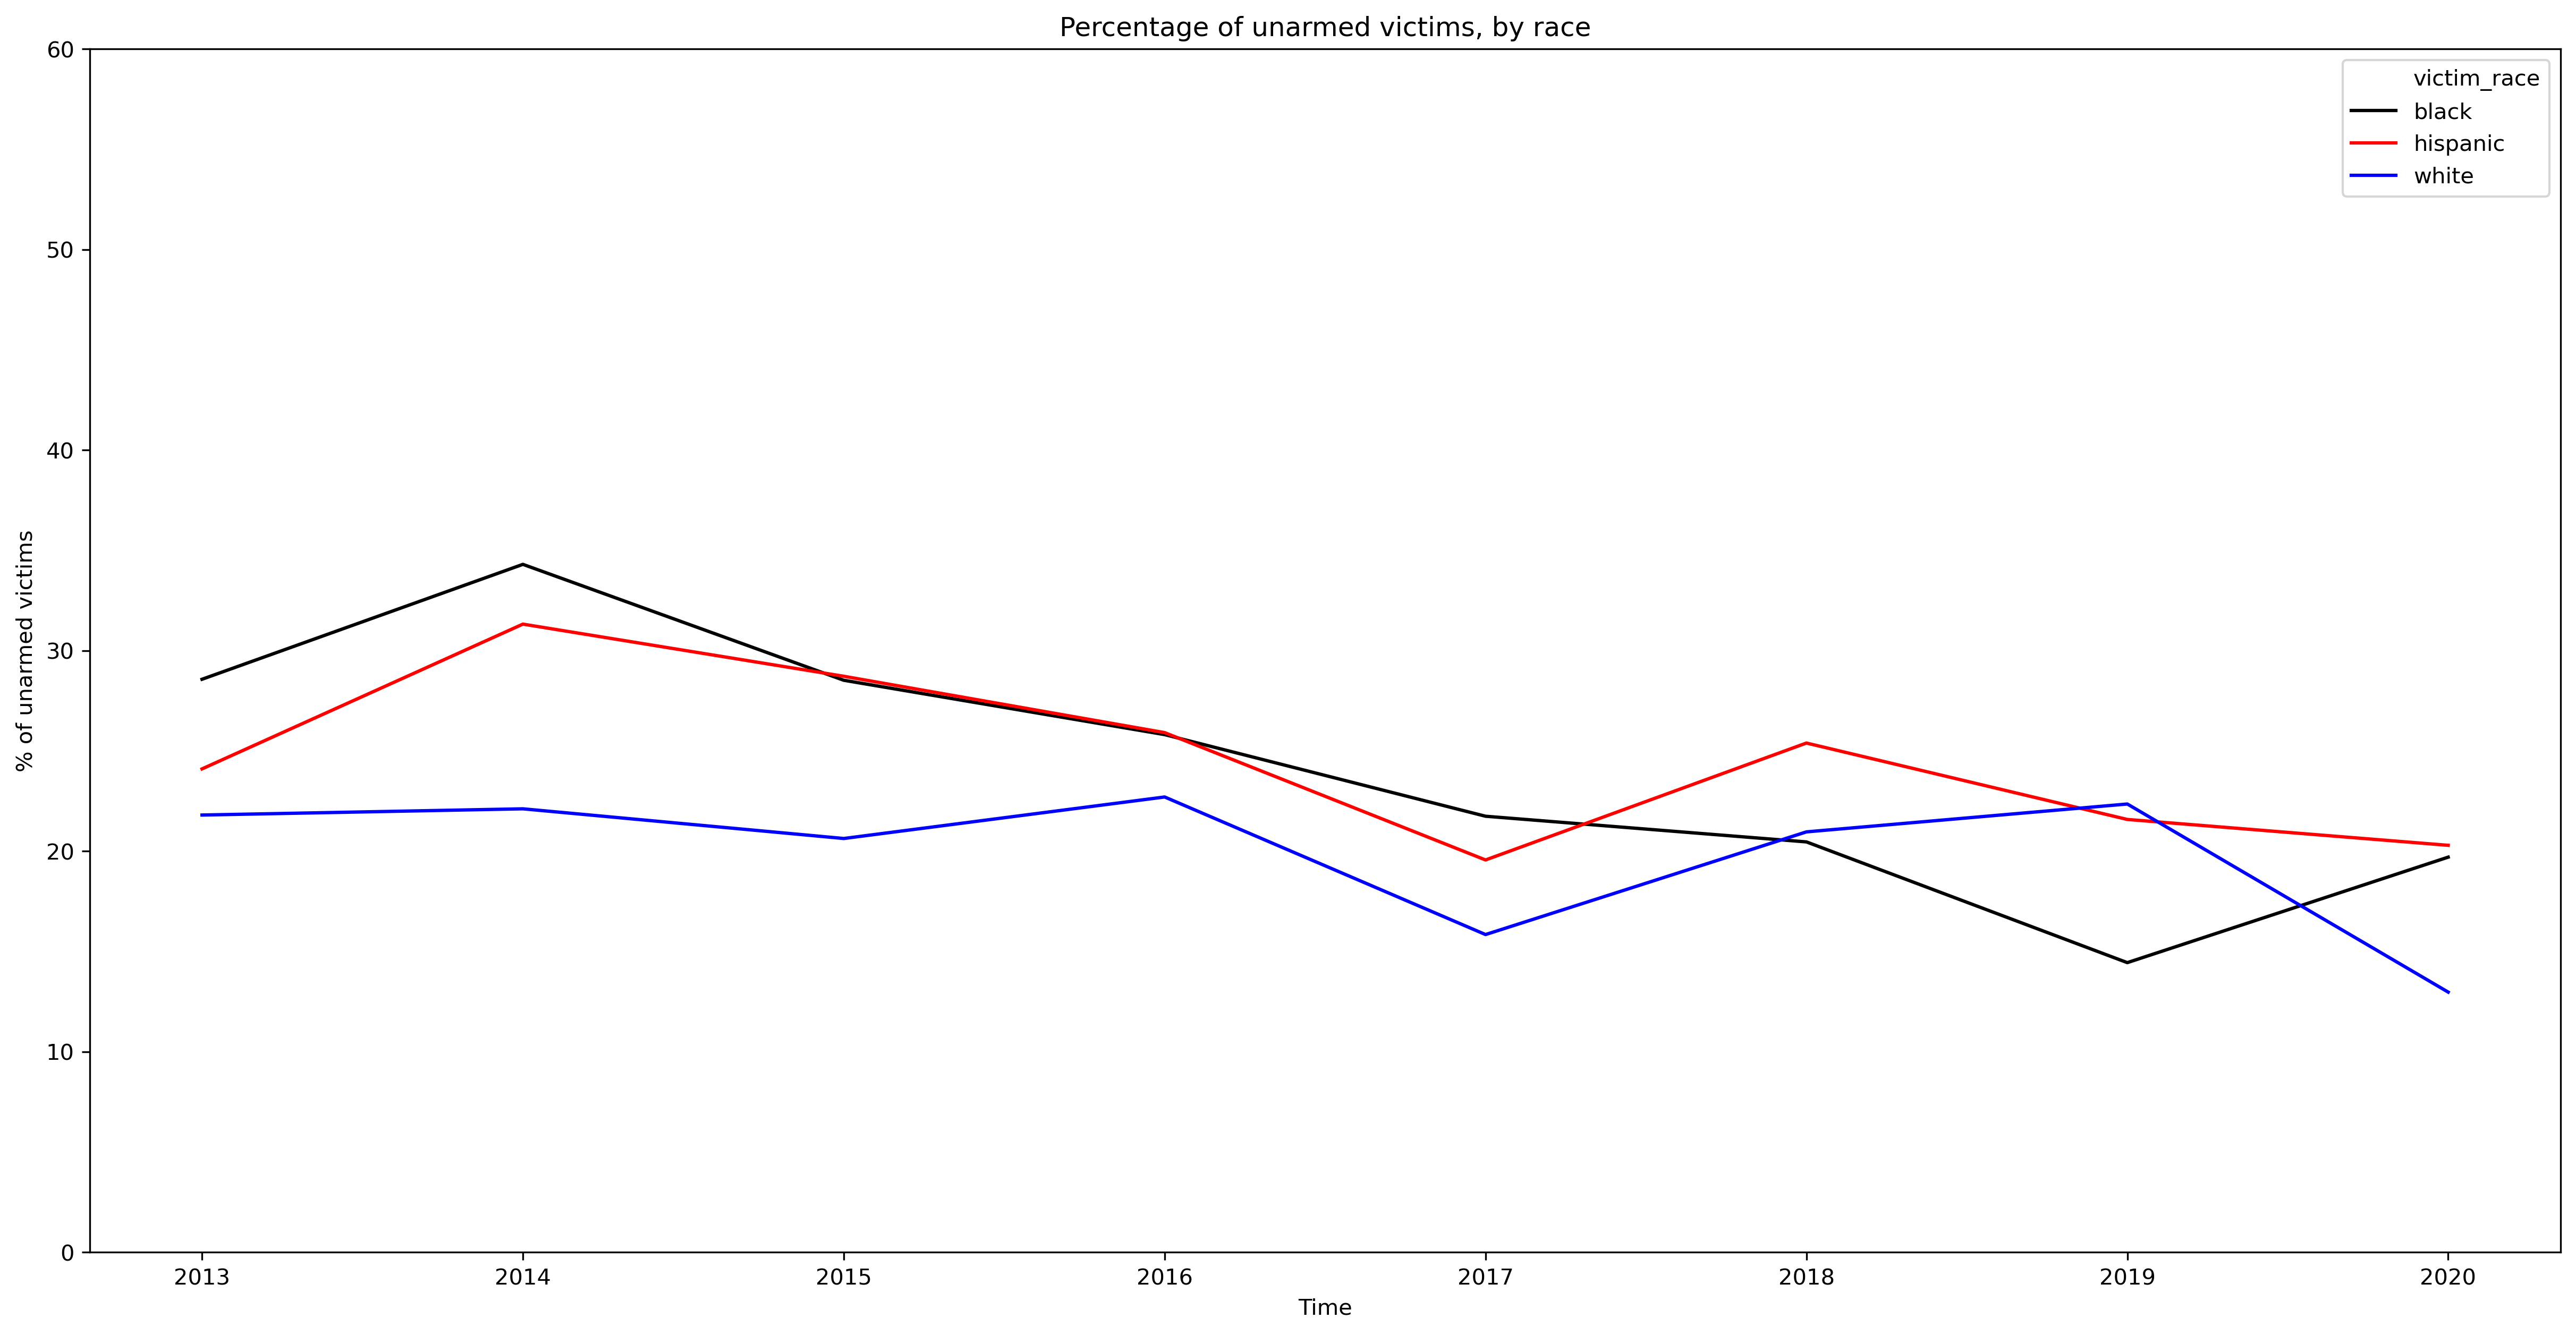

In [34]:
import seaborn as sns

fig, ax = plt.subplots()
fig.set_size_inches(20, 10)

sns.lineplot(data=final_df, x="date", y="%_unarmed", hue="victim_race", palette=["black", "red", "blue"])

ax.set_ylim(0, 60)

ax.set_title("Percentage of unarmed victims, by race")
ax.set_xlabel("Time")
ax.set_ylabel("% of unarmed victims")

**Comparison between races in the probability their murderer gets sentenced , between 2013 and 2020**

In [35]:
PV_data.head()

,victim_age,victim_gender,victim_race,date,City,State,cause_of_death,criminal_charges,victim_armed,alleged_weapon,victim_fleeing
0,66.0,Male,hispanic,2020,Tyler,TX,Gunshot,No known charges,Allegedly Armed,unknown weapon,not fleeing
2,28.0,Male,white,2020,St. Augustine,FL,Gunshot,No known charges,Allegedly Armed,gun,NaN
7,35.0,Male,white,2020,Meredith,NH,Gunshot,No known charges,Unclear,undetermined,NaN
8,38.0,Male,hispanic,2020,Sacramento,CA,Gunshot,No known charges,Allegedly Armed,gun,NaN
10,40.0,Male,white,2020,Cantonment,FL,Gunshot,No known charges,Vehicle,vehicle,car


In [36]:
total_df.head()

,victim_race,date,total_count
0,black,2013,287
1,black,2014,277
2,black,2015,305
3,black,2016,279
4,black,2017,276


In [37]:
PV_data.criminal_charges.unique()

array(['No known charges', 'Charged'], dtype=object)

In [38]:
#group by race, year and criminal_charges => get the number of police charged, each year, in every race
charged_df = PV_data.query('criminal_charges == "Charged"')
charged_df = charged_df.groupby(['victim_race', 'date', 'criminal_charges'], as_index=False).count()
charged_df['charged_count'] = charged_df.State
charged_df.head()

,victim_race,date,criminal_charges,victim_age,victim_gender,City,State,cause_of_death,victim_armed,alleged_weapon,victim_fleeing,charged_count
0,black,2013,Charged,10,10,10,10,10,10,10,0,10
1,black,2014,Charged,10,10,10,10,10,10,10,0,10
2,black,2015,Charged,12,12,12,12,12,12,12,8,12
3,black,2016,Charged,9,9,9,9,9,9,9,9,9
4,black,2017,Charged,7,7,7,7,7,7,7,7,7


In [39]:
final_df = pd.merge(total_df, charged_df, on=['victim_race', 'date'])
final_df['%_charged'] = np.around(final_df.charged_count / final_df.total_count * 100, decimals=2)
final_df = final_df[['victim_race', 'date', '%_charged']]
final_df

,victim_race,date,%_charged
0,black,2013,3.48
1,black,2014,3.61
2,black,2015,3.93
3,black,2016,3.23
4,black,2017,2.54
5,black,2018,1.93
6,black,2019,2.17
7,black,2020,4.55
8,hispanic,2013,1.81
9,hispanic,2014,1.10


Text(0, 0.5, '% of charged murderers')

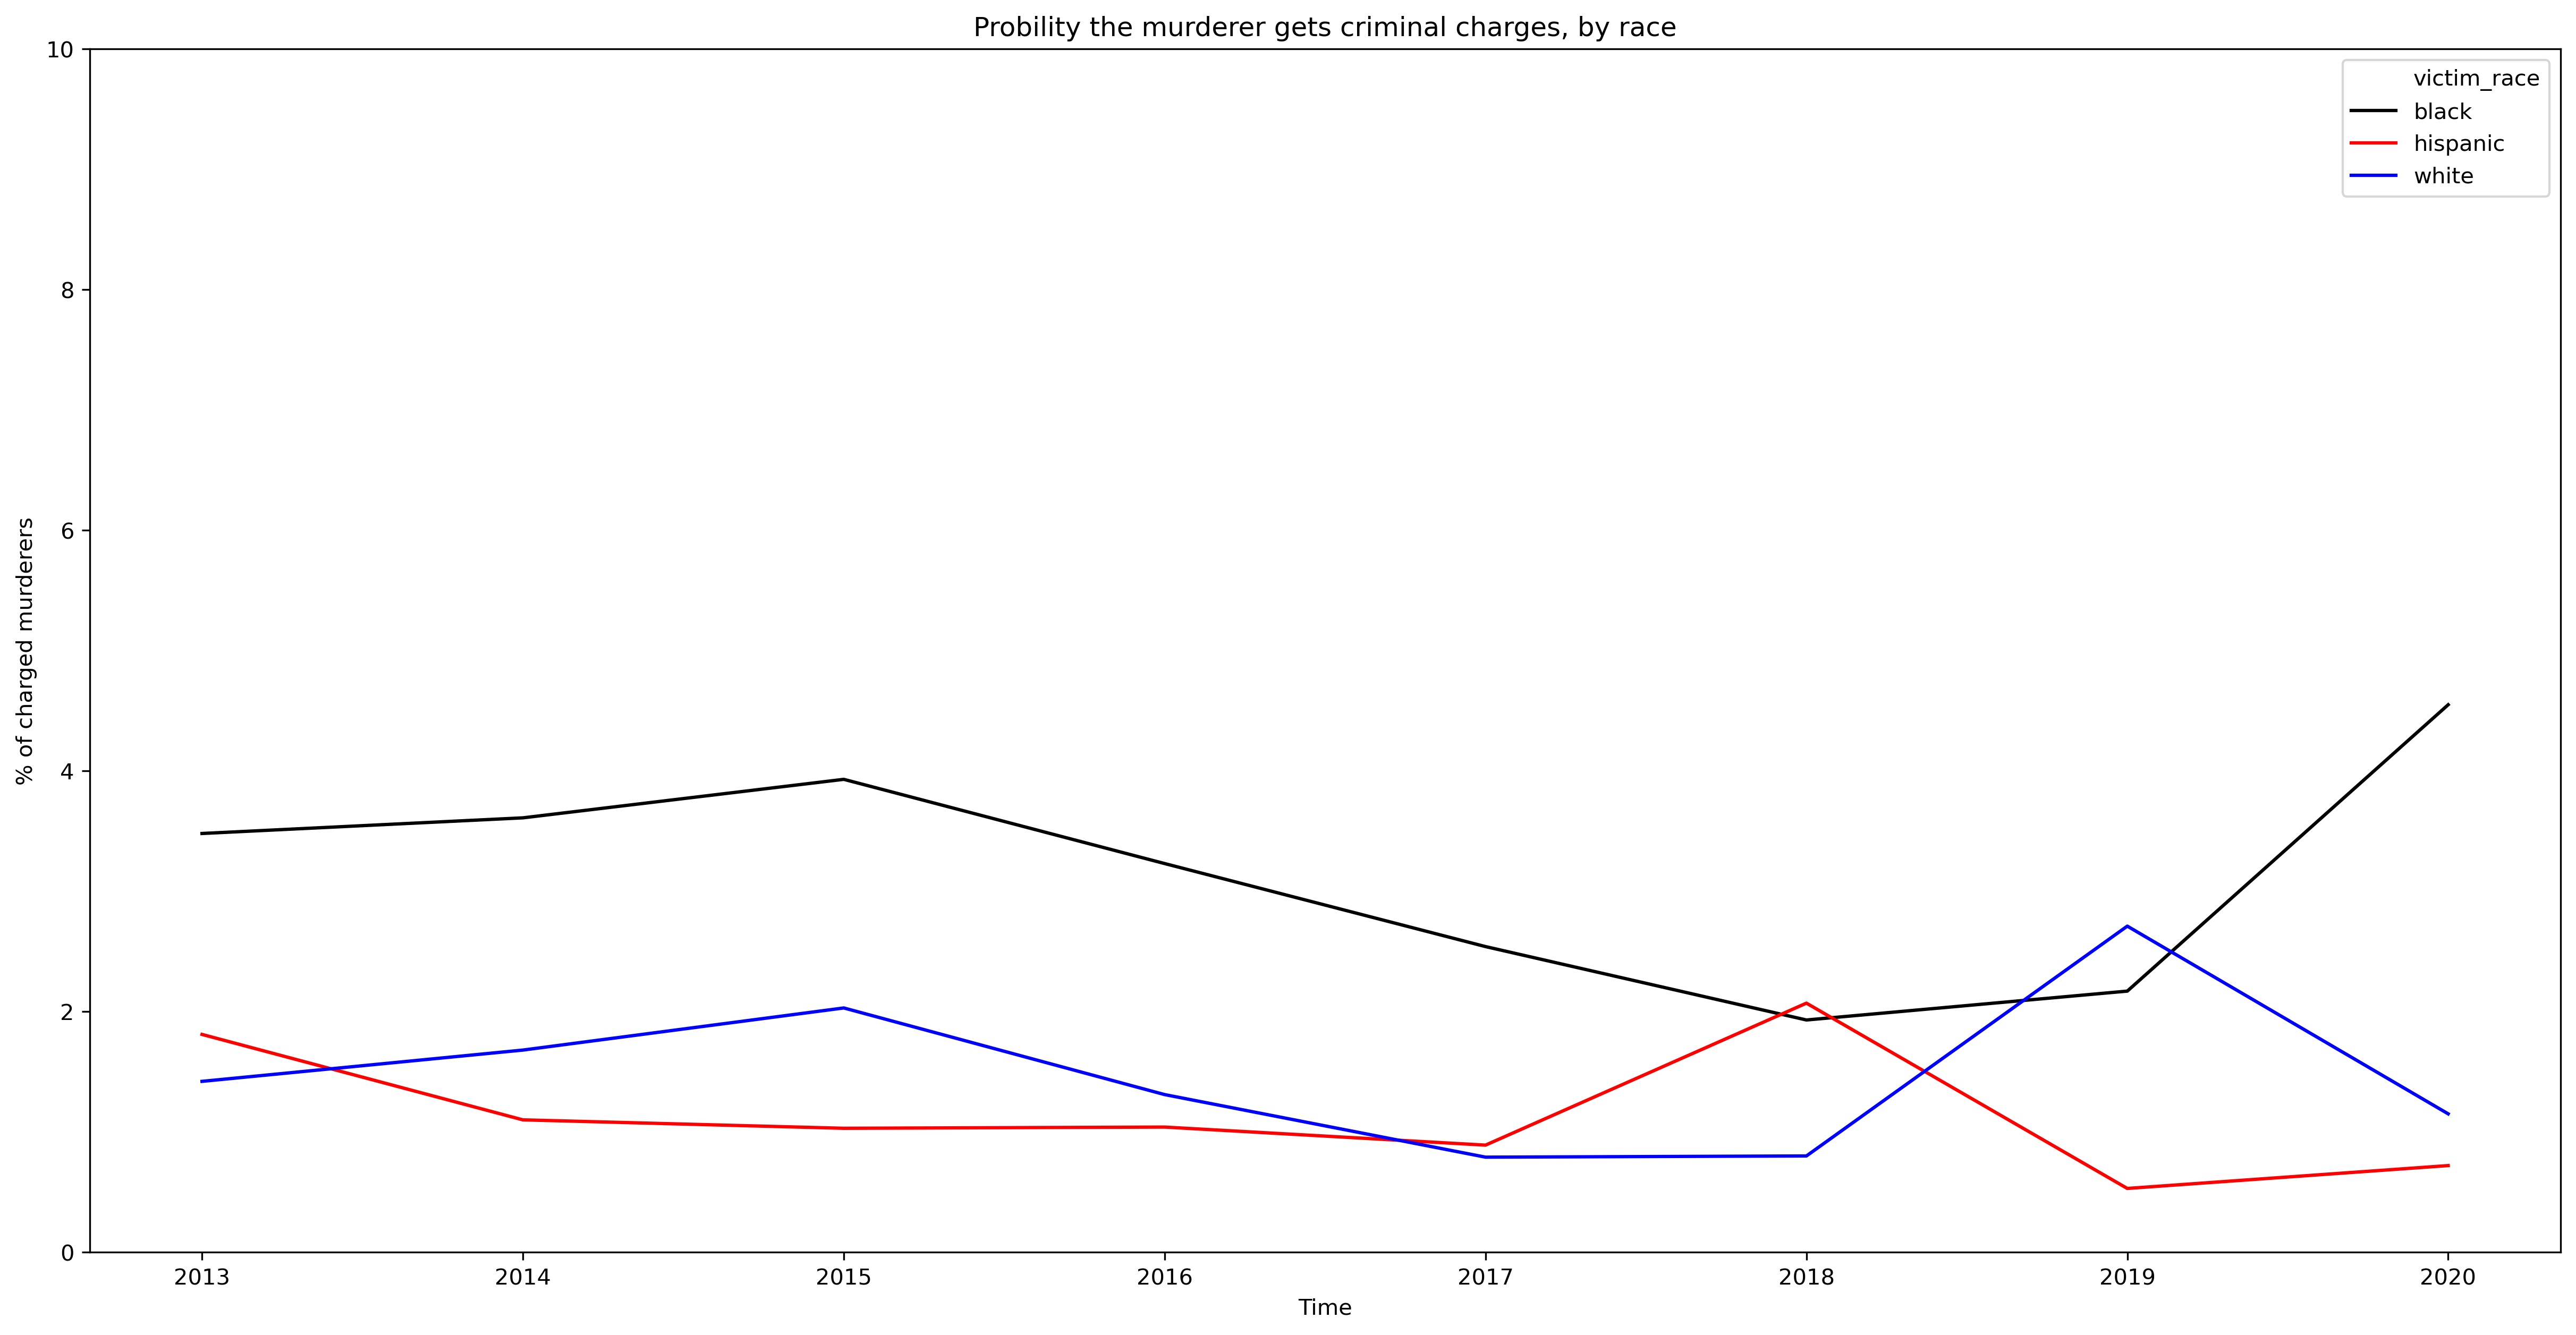

In [40]:
import seaborn as sns

fig, ax = plt.subplots()
fig.set_size_inches(20, 10)

sns.lineplot(data=final_df, x="date", y="%_charged", hue="victim_race", palette=["black", "red", "blue"])

ax.set_ylim(0, 10)

ax.set_title("Probility the murderer gets criminal charges, by race")
ax.set_xlabel("Time")
ax.set_ylabel("% of charged murderers")

**Comparison between races in the probability their murderer doesn't get charged , between 2013 and 2020**

In [41]:
PV_data.head()

,victim_age,victim_gender,victim_race,date,City,State,cause_of_death,criminal_charges,victim_armed,alleged_weapon,victim_fleeing
0,66.0,Male,hispanic,2020,Tyler,TX,Gunshot,No known charges,Allegedly Armed,unknown weapon,not fleeing
2,28.0,Male,white,2020,St. Augustine,FL,Gunshot,No known charges,Allegedly Armed,gun,NaN
7,35.0,Male,white,2020,Meredith,NH,Gunshot,No known charges,Unclear,undetermined,NaN
8,38.0,Male,hispanic,2020,Sacramento,CA,Gunshot,No known charges,Allegedly Armed,gun,NaN
10,40.0,Male,white,2020,Cantonment,FL,Gunshot,No known charges,Vehicle,vehicle,car


In [42]:
total_df.head()

,victim_race,date,total_count
0,black,2013,287
1,black,2014,277
2,black,2015,305
3,black,2016,279
4,black,2017,276


In [43]:
PV_data.criminal_charges.unique()

array(['No known charges', 'Charged'], dtype=object)

In [44]:
#group by race, year and criminal_charges => get the number of police charged, each year, in every race
not_charged_df = PV_data.query('criminal_charges == "No known charges"')
not_charged_df = not_charged_df.groupby(['victim_race', 'date', 'criminal_charges'], as_index=False).count()
not_charged_df['not_charged_count'] = not_charged_df.State
not_charged_df.head()

,victim_race,date,criminal_charges,victim_age,victim_gender,City,State,cause_of_death,victim_armed,alleged_weapon,victim_fleeing,not_charged_count
0,black,2013,No known charges,276,277,277,277,277,277,277,3,277
1,black,2014,No known charges,264,267,267,267,267,267,267,1,267
2,black,2015,No known charges,292,293,293,293,293,293,293,249,293
3,black,2016,No known charges,268,270,270,270,270,270,270,268,270
4,black,2017,No known charges,265,269,269,269,269,269,269,269,269


In [45]:
final_df = pd.merge(total_df, not_charged_df, on=['victim_race', 'date'])
final_df['%_not_charged'] = np.around(final_df.not_charged_count / final_df.total_count * 100, decimals=2)
final_df = final_df[['victim_race', 'date', '%_not_charged']]
final_df

,victim_race,date,%_not_charged
0,black,2013,96.52
1,black,2014,96.39
2,black,2015,96.07
3,black,2016,96.77
4,black,2017,97.46
5,black,2018,98.07
6,black,2019,97.83
7,black,2020,95.45
8,hispanic,2013,98.19
9,hispanic,2014,98.90


Text(0, 0.5, '% of non charged murderers')

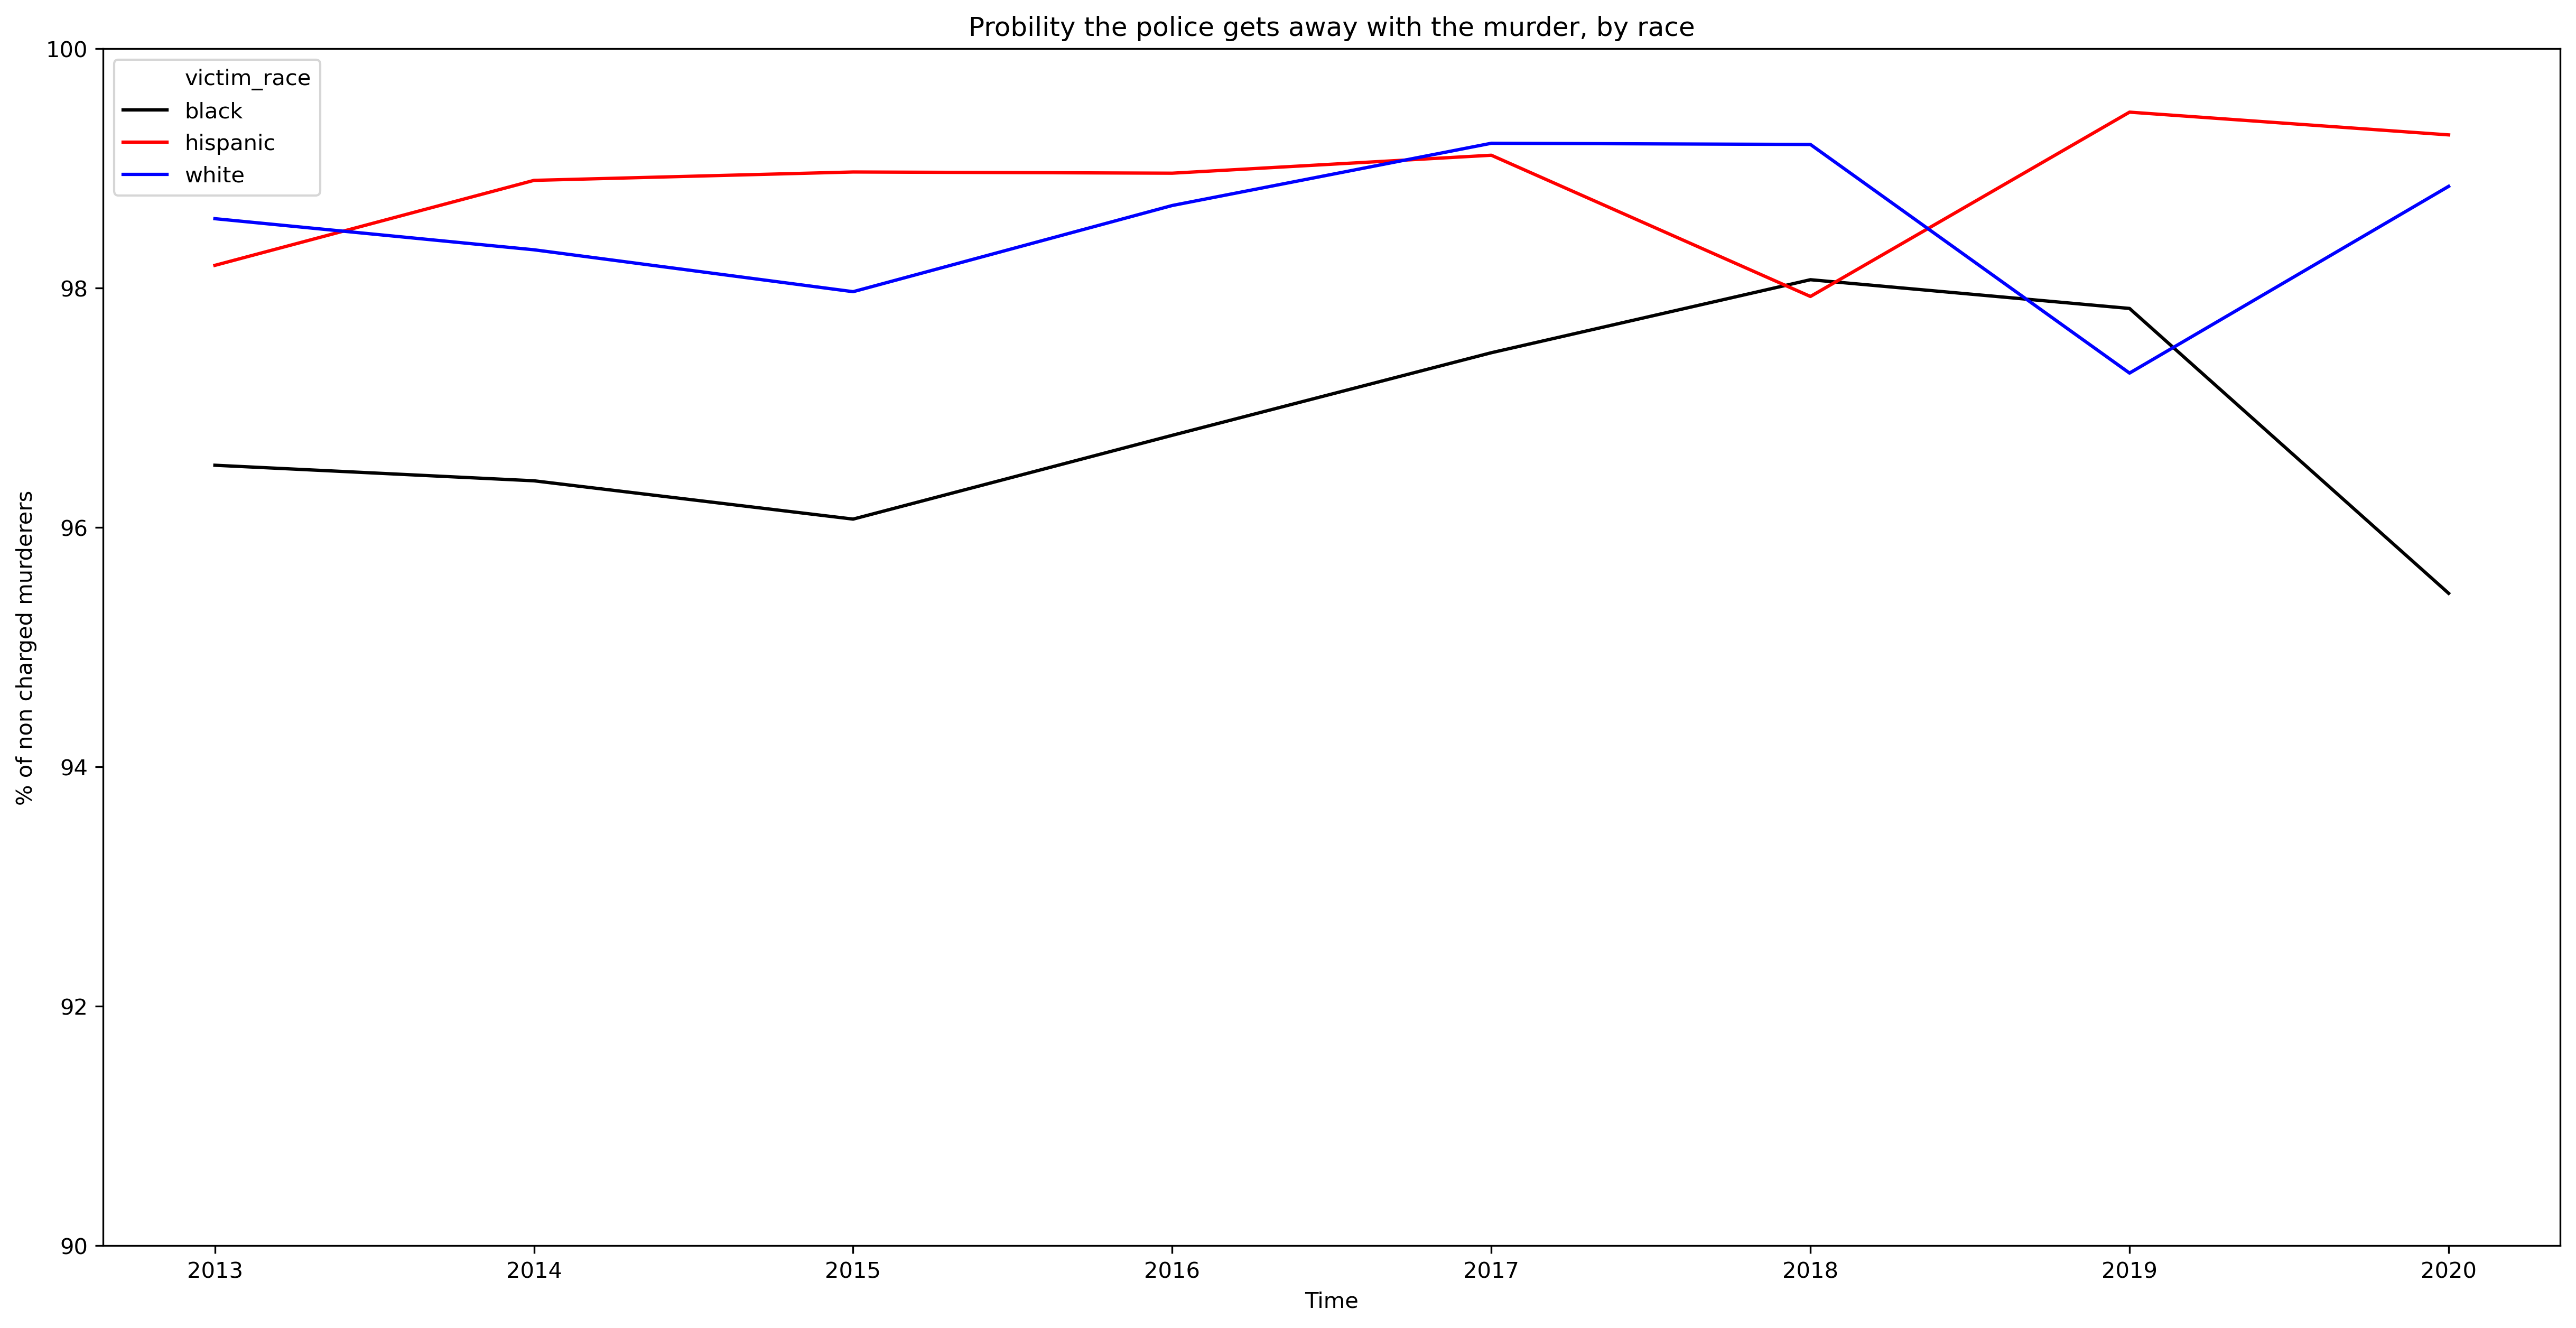

In [46]:
import seaborn as sns

fig, ax = plt.subplots()
fig.set_size_inches(20, 10)

sns.lineplot(data=final_df, x="date", y="%_not_charged", hue="victim_race", palette=["black", "red", "blue"])

ax.set_ylim(90, 100)

ax.set_title("Probility the police gets away with the murder, by race")
ax.set_xlabel("Time")
ax.set_ylabel("% of non charged murderers")